# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan

from scipy.stats import beta

from datetime import datetime

# Exercise 1: Rocket Data

In [2]:
rockets = pd.read_csv("data/failure_counts.csv")
rockets

,LV.Type,numberOfLaunches,numberOfFailures
0,Aerobee,1,0
1,Angara A5,1,0
2,Antares 110,2,0
3,Antares 120,2,0
4,Antares 130,1,1
...,...,...,...
362,Zenit-2M,1,0
363,Zenit-2SB,1,0
364,Zenit-3SL,36,3
365,Zenit-3SLB,6,0


### Pystan model setup

In [3]:
model = """
data {
    int<lower=0> n;  // number of trials (launches) in a Binomial distribution with lower bound 0
    int<lower=0> X;  // number of successes in a Binomial distribution with lower bound 0
    real<lower=0> a; // parameter a for a Beta distribution with lower bound 0
    real<lower=0> b; // parameter b for a Beta distribution with lower bound 0
}
parameters {
    real <lower=0,upper=1> p; // probability of success in a Binomial distribution with lower and upper bounds, 0 and 1
}
model {
    p ~ beta(a,b);
    X ~ binomial(n,p);
}
"""

### Sampling

In [4]:
# Put data in a dictionary
data = {'n': 20, 'X': 10, 'a': 1, 'b': 1}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=10000, chains=1, warmup=1000, thin=5, seed=553)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2dfdc360ff21a08b0fd577cfd94fbfce NOW.


In [5]:
fit

Inference for Stan model: anon_model_2dfdc360ff21a08b0fd577cfd94fbfce.
1 chains, each with iter=10000; warmup=1000; thin=5; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p       0.5  2.8e-3   0.11   0.29   0.43    0.5   0.57   0.69   1453    1.0
lp__ -15.77    0.02   0.72 -17.95 -15.95 -15.48  -15.3 -15.25   1665    1.0

Samples were drawn using NUTS at Thu Sep 15 15:24:19 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [6]:
posterior_rockets = pd.DataFrame({"p": fit['p'], "lp__": fit['lp__']})
posterior_rockets

,p,lp__
0,0.430306,-15.465059
1,0.458744,-15.324385
2,0.451962,-15.351244
3,0.403497,-15.666832
4,0.557686,-15.396638
...,...,...
1795,0.314243,-16.883018
1796,0.471832,-15.284206
1797,0.419690,-15.536747
1798,0.354654,-16.220393


### Q1.1: Visualize the Posterior Distribution of $p$ for a "Made-Up Rocket" using $\text{Beta}(a = 1, b = 1)$ Prior

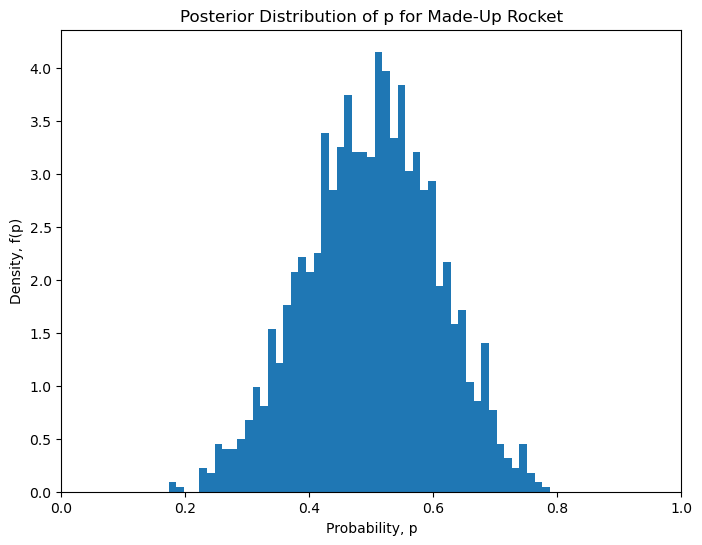

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(posterior_rockets["p"], density=True, bins=50)
plt.title("Posterior Distribution of p for Made-Up Rocket")
plt.xlabel('Probability, p')
plt.ylabel('Density, f(p)')
plt.xlim(0, 1)
plt.show();

### Q1.2: Sample from the Posterior Distribution of $p$ for `Zenit-3SL`

In [8]:
Zenit_3SL_observed_data = rockets[rockets["LV.Type"] == 'Zenit-3SL']
Zenit_3SL_observed_data

,LV.Type,numberOfLaunches,numberOfFailures
364,Zenit-3SL,36,3


In [9]:
data_Zenit_3SL = {
    'n': Zenit_3SL_observed_data["numberOfLaunches"].values[0],
    'X': Zenit_3SL_observed_data["numberOfLaunches"].values[0] - Zenit_3SL_observed_data["numberOfFailures"].values[0],
    'a': 1,
    'b': 1
}

fit_Zenit_3SL = sm.sampling(data=data_Zenit_3SL, iter=10000, chains=1, warmup=1000, thin=5, seed=553)

In [10]:
fit_Zenit_3SL

Inference for Stan model: anon_model_2dfdc360ff21a08b0fd577cfd94fbfce.
1 chains, each with iter=10000; warmup=1000; thin=5; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p       0.9  1.2e-3   0.05   0.79   0.87    0.9   0.93   0.97   1620    1.0
lp__ -13.29    0.02    0.7  -15.2 -13.45 -13.02 -12.84 -12.79   1677    1.0

Samples were drawn using NUTS at Thu Sep 15 15:24:20 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [11]:
posterior_Zenit_3SL = pd.DataFrame({"p": fit_Zenit_3SL['p'], "lp__": fit_Zenit_3SL['lp__']})
posterior_Zenit_3SL

,p,lp__
0,0.939479,-13.341675
1,0.993049,-20.112824
2,0.871149,-12.886427
3,0.876490,-12.847953
4,0.950542,-13.751115
...,...,...
1795,0.876741,-12.846354
1796,0.861386,-12.977479
1797,0.773670,-14.667775
1798,0.814203,-13.720944


### Q1.3: Visualize from the Posterior Distribution of $p$ for Zenit-3SL using $\text{Beta}(a = 1, b = 1)$ Prior

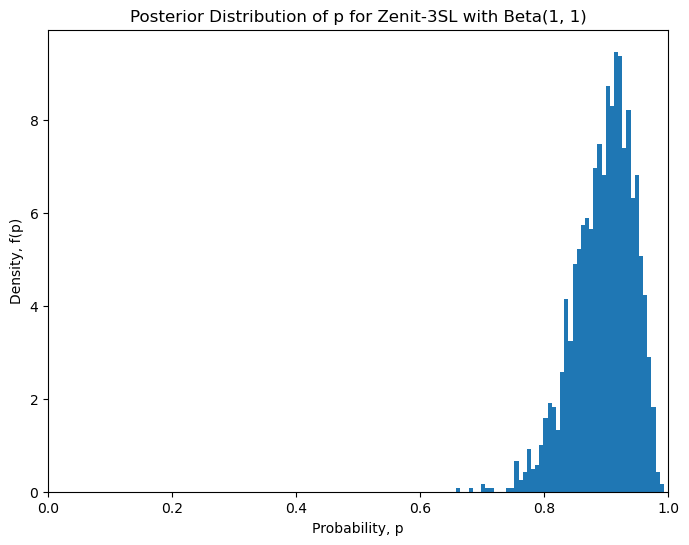

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(posterior_Zenit_3SL["p"], density=True, bins=50)
plt.title("Posterior Distribution of p for Zenit-3SL with Beta(1, 1)")
plt.xlabel('Probability, p')
plt.ylabel('Density, f(p)')
plt.xlim(0, 1)
plt.show();

### Q1.4: Summary Statistics for the Posterior Samples of Zenit-3SL using $\text{Beta}(a = 1, b = 1)$ Prior

In [13]:
np.mean(posterior_Zenit_3SL["p"])

0.8960425791271323

In [14]:
np.median(posterior_Zenit_3SL["p"])

0.9020735909165447

In [15]:
np.var(posterior_Zenit_3SL["p"])

0.002264274575818576

In [16]:
percentiles = (0.05, 0.95)
print(pystan.stansummary(fit=fit_Zenit_3SL, probs=percentiles))

Inference for Stan model: anon_model_2dfdc360ff21a08b0fd577cfd94fbfce.
1 chains, each with iter=10000; warmup=1000; thin=5; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

       mean se_mean     sd     5%    95%  n_eff   Rhat
p       0.9  1.2e-3   0.05   0.81   0.96   1620    1.0
lp__ -13.29    0.02    0.7  -14.7 -12.79   1677    1.0

Samples were drawn using NUTS at Thu Sep 15 15:24:20 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Exercise 2: Rocket Data (Revisited)

In [17]:
Zenit_3SL_observed_data

,LV.Type,numberOfLaunches,numberOfFailures
364,Zenit-3SL,36,3


### Q2.1: Plotting the Beta Distribution

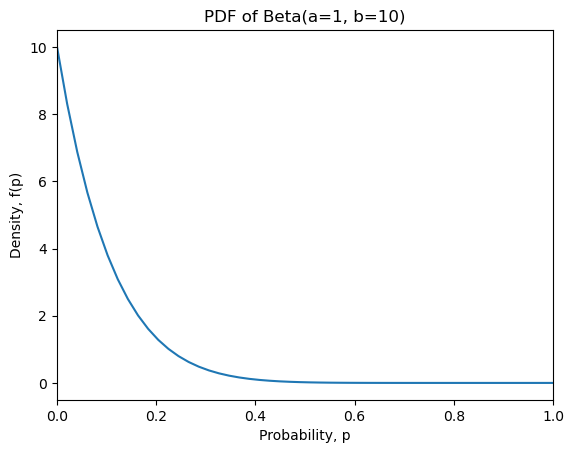

In [18]:
a, b = 1, 10
x = np.linspace(0, 1)
rv = beta(a, b)
plt.plot(x, rv.pdf(x))
plt.title("PDF of Beta(a=1, b=10)")
plt.xlabel("Probability, p")
plt.ylabel("Density, f(p)")
plt.xlim(0, 1)
plt.show();

### Q2.2: Rerunning the Bayesian Simulation

In [19]:
data_Zenit_3SL_2 = {
    'n': Zenit_3SL_observed_data["numberOfLaunches"].values[0],
    'X': Zenit_3SL_observed_data["numberOfLaunches"].values[0] - Zenit_3SL_observed_data["numberOfFailures"].values[0],
    'a': 1,
    'b': 10
}

fit_Zenit_3SL_2 = sm.sampling(data=data_Zenit_3SL_2, iter=10000, chains=1, warmup=1000, thin=5, seed=553)

In [20]:
posterior_Zenit_3SL_2 = pd.DataFrame({"p": fit_Zenit_3SL_2['p'], "lp__": fit_Zenit_3SL_2['lp__']})
posterior_Zenit_3SL_2

,p,lp__
0,0.665669,-28.079844
1,0.652306,-28.259829
2,0.746125,-27.779187
3,0.739036,-27.745742
4,0.706726,-27.748238
...,...,...
1795,0.774014,-28.044285
1796,0.802457,-28.566010
1797,0.678314,-27.941258
1798,0.568247,-30.135477


### Q2.3: Visualize from the Posterior Distribution of $p$ for Zenit-3SL using $\text{Beta}(a = 1, b = 10)$ Prior

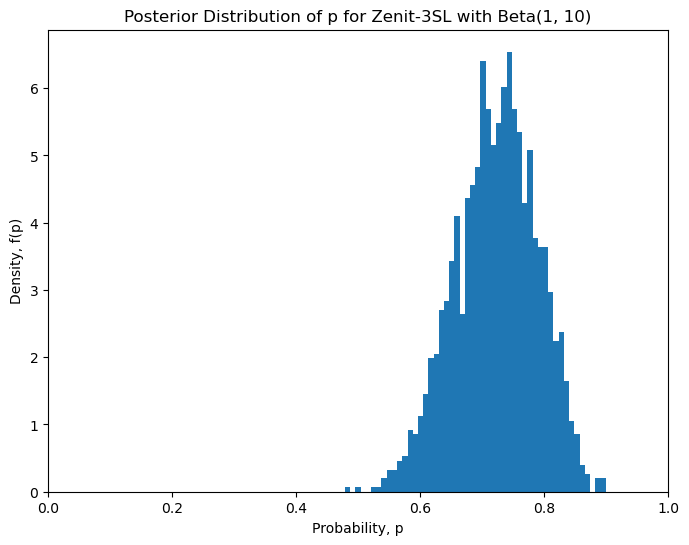

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(posterior_Zenit_3SL_2["p"], density=True, bins=50)
plt.title("Posterior Distribution of p for Zenit-3SL with Beta(1, 10)")
plt.xlabel('Probability, p')
plt.ylabel('Density, f(p)')
plt.xlim(0, 1)
plt.show();

### Q2.4: Summary Statistics for the Posterior Samples of Zenit-3SL using $\text{Beta}(a = 1, b = 10)$ Prior

In [22]:
np.mean(posterior_Zenit_3SL_2["p"])

0.7226833253314187

In [23]:
np.median(posterior_Zenit_3SL_2["p"])

0.7257739655840236

In [24]:
np.var(posterior_Zenit_3SL_2["p"])

0.004342315576225412

In [25]:
percentiles = (0.05, 0.95)
print(pystan.stansummary(fit=fit_Zenit_3SL_2, probs=percentiles))

Inference for Stan model: anon_model_2dfdc360ff21a08b0fd577cfd94fbfce.
1 chains, each with iter=10000; warmup=1000; thin=5; 
post-warmup draws per chain=1800, total post-warmup draws=1800.

       mean se_mean     sd     5%    95%  n_eff   Rhat
p      0.72  1.5e-3   0.07   0.61   0.83   1891    1.0
lp__ -28.25    0.02   0.72 -29.69 -27.72   1693    1.0

Samples were drawn using NUTS at Thu Sep 15 15:24:20 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Q2.5: Comparing Bayesian Analyses of Priors Beta(a = 1, b = 1) and Beta(a = 1, b = 10)

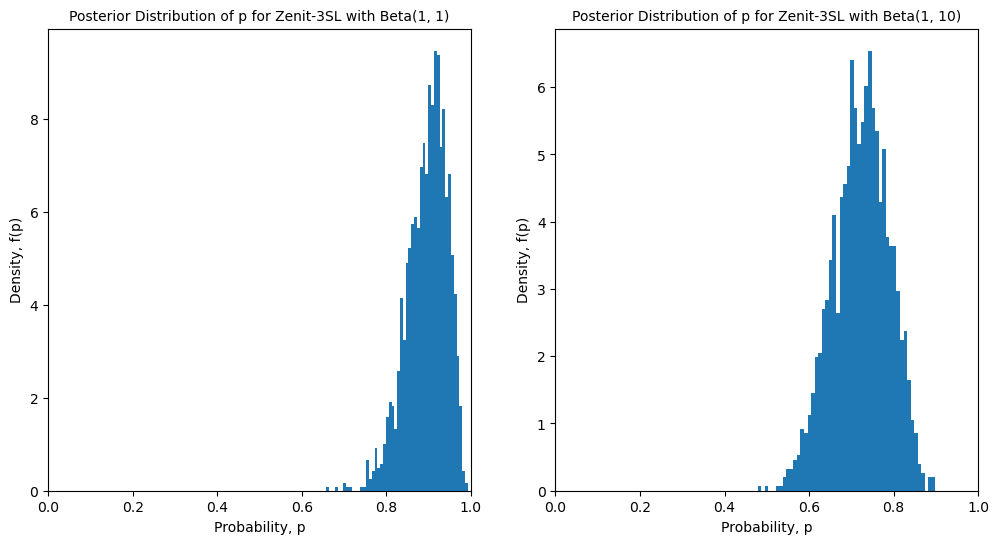

In [26]:
fig, axs = plt.subplots(1, 2,  figsize=(12, 6))

axs[0].hist(posterior_Zenit_3SL["p"], density=True, bins=50)
axs[0].set_title("Posterior Distribution of p for Zenit-3SL with Beta(1, 1)", fontsize=10)
axs[0].set_xlabel('Probability, p')
axs[0].set_ylabel('Density, f(p)')
axs[0].set_xlim(0, 1)

axs[1].hist(posterior_Zenit_3SL_2["p"], density=True, bins=50)
axs[1].set_title("Posterior Distribution of p for Zenit-3SL with Beta(1, 10)", fontsize=10)
axs[1].set_xlabel('Probability, p')
axs[1].set_ylabel('Density, f(p)')
axs[1].set_xlim(0, 1)

plt.show();

### Q2.7: Reducing Observed Data using $\text{Beta}(a = 1, b = 1)$ Prior

In [27]:
data_Zenit_3SL_red = {
    'n': int(Zenit_3SL_observed_data["numberOfLaunches"].values[0]/3),
    'X': int(Zenit_3SL_observed_data["numberOfLaunches"].values[0]/3 - Zenit_3SL_observed_data["numberOfFailures"].values[0]/3),
    'a': 1,
    'b': 1
}

fit_Zenit_3SL_red = sm.sampling(data=data_Zenit_3SL_red, iter=10000, chains=1, warmup=1000, thin=5, seed=553)

In [28]:
posterior_Zenit_3SL_red = pd.DataFrame({"p": fit_Zenit_3SL_red['p'], "lp__": fit_Zenit_3SL_red['lp__']})
posterior_Zenit_3SL_red

,p,lp__
0,0.833672,-5.770570
1,0.850566,-5.744040
2,0.988970,-9.147298
3,0.770127,-6.074853
4,0.801835,-5.887539
...,...,...
1795,0.821897,-5.804468
1796,0.895624,-5.842329
1797,0.884160,-5.788496
1798,0.940443,-6.378491


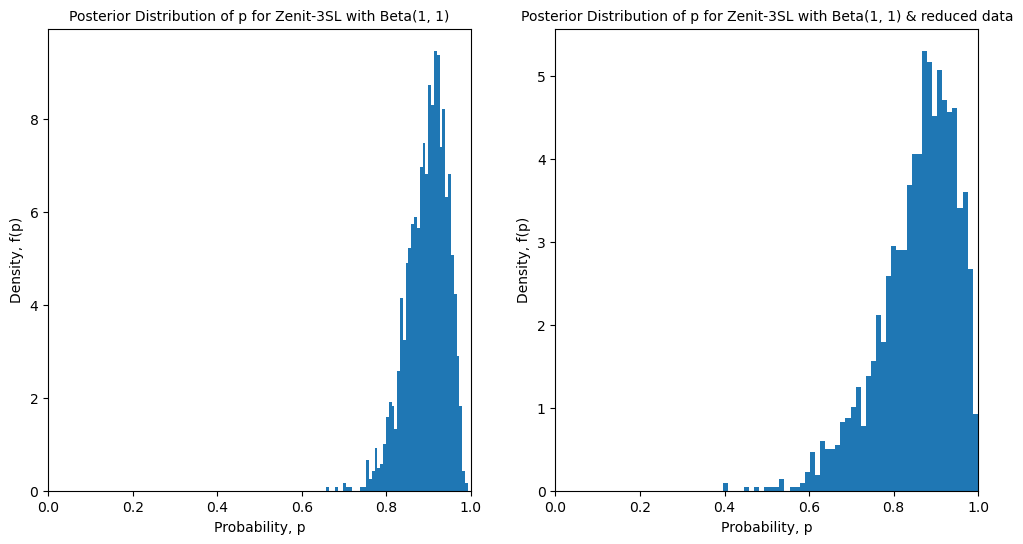

In [29]:
fig, axs = plt.subplots(1, 2,  figsize=(12, 6))

axs[0].hist(posterior_Zenit_3SL["p"], density=True, bins=50)
axs[0].set_title("Posterior Distribution of p for Zenit-3SL with Beta(1, 1)", fontsize=10)
axs[0].set_xlabel('Probability, p')
axs[0].set_ylabel('Density, f(p)')
axs[0].set_xlim(0, 1)

axs[1].hist(posterior_Zenit_3SL_red["p"], density=True, bins=50)
axs[1].set_title("Posterior Distribution of p for Zenit-3SL with Beta(1, 1) & reduced data", fontsize=10)
axs[1].set_xlabel('Probability, p')
axs[1].set_ylabel('Density, f(p)')
axs[1].set_xlim(0, 1)

plt.show();

### Q2.8: Reducing Observed Data using Beta(a = 1, b = 10) Prior

In [30]:
data_Zenit_3SL_2_red = {
    'n': int(Zenit_3SL_observed_data["numberOfLaunches"].values[0]/3),
    'X': int(Zenit_3SL_observed_data["numberOfLaunches"].values[0]/3 - Zenit_3SL_observed_data["numberOfFailures"].values[0]/3),
    'a': 1,
    'b': 10
}

fit_Zenit_3SL_2_red = sm.sampling(data=data_Zenit_3SL_2_red, iter=10000, chains=1, warmup=1000, thin=5, seed=553)

In [31]:
posterior_Zenit_3SL_2_red = pd.DataFrame({"p": fit_Zenit_3SL_2_red['p'], "lp__": fit_Zenit_3SL_2_red['lp__']})
posterior_Zenit_3SL_2_red

,p,lp__
0,0.553115,-15.966266
1,0.378688,-16.887650
2,0.600629,-16.213841
3,0.474653,-16.022713
4,0.643121,-16.631008
...,...,...
1795,0.549094,-15.955287
1796,0.492090,-15.961085
1797,0.523533,-15.920787
1798,0.651749,-16.740299


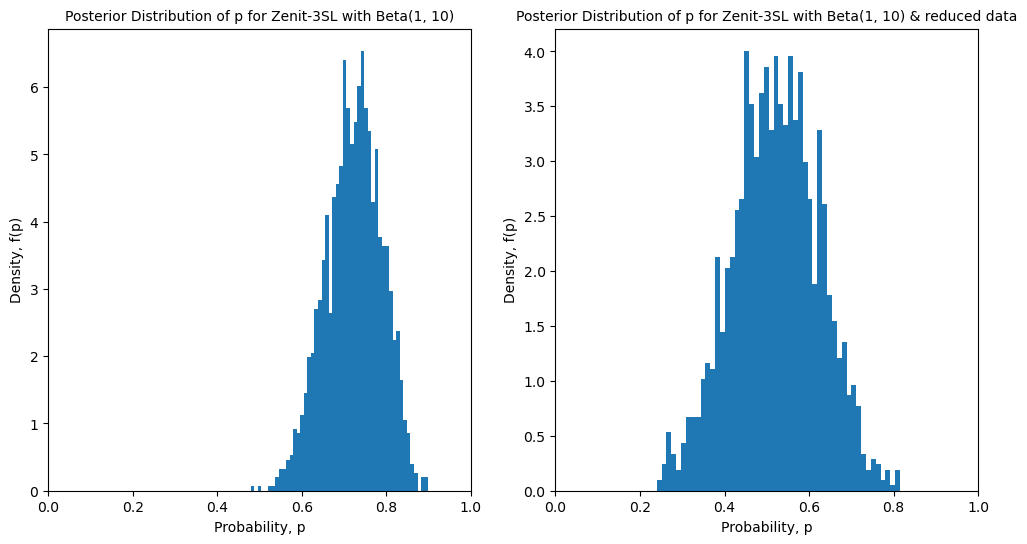

In [32]:
fig, axs = plt.subplots(1, 2,  figsize=(12, 6))

axs[0].hist(posterior_Zenit_3SL_2["p"], density=True, bins=50)
axs[0].set_title("Posterior Distribution of p for Zenit-3SL with Beta(1, 10)", fontsize=10)
axs[0].set_xlabel('Probability, p')
axs[0].set_ylabel('Density, f(p)')
axs[0].set_xlim(0, 1)

axs[1].hist(posterior_Zenit_3SL_2_red["p"], density=True, bins=50)
axs[1].set_title("Posterior Distribution of p for Zenit-3SL with Beta(1, 10) & reduced data", fontsize=10)
axs[1].set_xlabel('Probability, p')
axs[1].set_ylabel('Density, f(p)')
axs[1].set_xlim(0, 1)

plt.show();

# Exercise 3: Play Ball!

In [33]:
games_raw = pd.read_csv("data/games.csv")
games_raw

,attendance,away_final_score,away_team,date,elapsed_time,home_final_score,home_team
0,35055,3,sln,2015-04-05,184,0,chn
1,45909,1,ana,2015-04-06,153,4,sea
2,36969,2,atl,2015-04-06,156,1,mia
3,31042,6,bal,2015-04-06,181,2,tba
4,45549,8,bos,2015-04-06,181,0,phi
...,...,...,...,...,...,...,...
4852,24856,3,oak,2016-10-02,154,2,sea
4853,44615,4,pit,2016-10-02,192,10,sln
4854,31385,2,sdn,2016-10-02,157,3,ari
4855,37015,6,tba,2016-10-02,240,4,tex


### Data Wrangling

In [34]:
games_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857 entries, 0 to 4856
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   attendance        4857 non-null   int64 
 1   away_final_score  4857 non-null   int64 
 2   away_team         4857 non-null   object
 3   date              4857 non-null   object
 4   elapsed_time      4857 non-null   int64 
 5   home_final_score  4857 non-null   int64 
 6   home_team         4857 non-null   object
dtypes: int64(4), object(3)
memory usage: 265.7+ KB


In [35]:
# Extract the year from the column, date
games_raw["date"] = games_raw["date"].str.split("-", expand=True)[0]
games_raw["date"] = games_raw["date"].astype("int")

In [36]:
# Choose only 2016
games_raw = games_raw.query("date == 2016")
games_raw = games_raw.query("away_final_score != home_final_score")

In [37]:
games_raw

,attendance,away_final_score,away_team,date,elapsed_time,home_final_score,home_team
2429,40030,3,nyn,2016,193,4,kca
2430,39500,1,sln,2016,182,4,pit
2431,31042,5,tor,2016,171,3,tba
2432,35067,4,cha,2016,176,3,oak
2433,44020,9,chn,2016,188,0,ana
...,...,...,...,...,...,...,...
4852,24856,3,oak,2016,154,2,sea
4853,44615,4,pit,2016,192,10,sln
4854,31385,2,sdn,2016,157,3,ari
4855,37015,6,tba,2016,240,4,tex


In [38]:
# Create a dictionary of IDs, and assign numerical codes from 1 to 30 according to the alphabetical order

teams = sorted(games_raw["away_team"].unique())
code = [i for i in range(1, 31, 1)]

dictionary_names = {}

for i in range(30):
    dictionary_names[teams[i]] = code[i]

In [39]:
cols = ["date", "away_final_score", "away_team", "home_final_score", "home_team"]
games_temp = games_raw[cols]

In [40]:
games = games_temp.copy()

for i in range(len(games)):
    games["away_team"].iloc[i] = dictionary_names[games_temp["away_team"].iloc[i]]
    games["home_team"].iloc[i] = dictionary_names[games_temp["home_team"].iloc[i]]

C:\Users\johnw\miniconda3\envs\stan_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [41]:
# Create columns that will be used in the analysis

def winning_team(games):
    if games["away_final_score"] > games["home_final_score"]:
        return "away"
    else:
        return "home"

def losing_team(games):
    if games["away_final_score"] > games["home_final_score"]:
        return "home"
    else:
        return "away"

In [42]:
games["winning_team"] = np.NaN
games["winning_score"] = np.NaN
games["losing_team"] = np.NaN
games["losing_score"] = np.NaN

winning_teams = games.apply(winning_team, axis=1).values
losing_teams = games.apply(losing_team, axis=1).values

for i in range(len(games)):
    games["winning_team"].iloc[i] = games[f"{winning_teams[i]}_team"].iloc[i]
    games["winning_score"].iloc[i] = games[f"{winning_teams[i]}_final_score"].iloc[i]
    games["losing_team"].iloc[i] = games[f"{losing_teams[i]}_team"].iloc[i]
    games["losing_score"].iloc[i] = games[f"{losing_teams[i]}_final_score"].iloc[i]

In [43]:
games["score_diff"] = games["winning_score"] - games["losing_score"]

new_cols = ["winning_team", "winning_score", "losing_team", "losing_score", "score_diff"]

games = games[new_cols]

games = games.astype("int")
# games["winning_team"] = games["winning_team"].astype("category")
# games["losing_team"] = games["losing_team"].astype("category")

In [44]:
games

,winning_team,winning_score,losing_team,losing_score,score_diff
2429,13,4,19,3,1
2430,22,4,26,1,3
2431,29,5,27,3,2
2432,6,4,20,3,1
2433,7,9,1,0,9
...,...,...,...,...,...
4852,20,3,24,2,1
4853,26,10,22,4,6
4854,2,3,23,2,1
4855,27,6,28,4,2


In [45]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2418 entries, 2429 to 4856
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   winning_team   2418 non-null   int32
 1   winning_score  2418 non-null   int32
 2   losing_team    2418 non-null   int32
 3   losing_score   2418 non-null   int32
 4   score_diff     2418 non-null   int32
dtypes: int32(5)
memory usage: 66.1 KB


### Code the Model

In [46]:
model = """
data {
    int<lower=0> N; // number of games in dataset (an integer larger or equal than zero)
    int<lower=0> t;  // number of teams (an integer larger or equal than zero)
    int<lower=1> win_team[N];   // winning team ID VECTOR (size N of integer-type) whose IDs are larger or equal than one
    int<lower=1> lose_team[N]; // losing team ID VECTOR (size N of integer-type) whose IDs are larger or equal than one
    int<lower=0> score_diff[N]; // VECTOR of score differences (size N of integer-type) with values equal or larger than zero 
}
parameters {
    vector<lower=0>[t] skill; // nonnegative VECTOR of posterior skills (i.e, larger or equal than zero) for t teams (size t)
}
model {
    for (j in 1:t){
      skill[j] ~ gamma(1, 1);
    }
    for (i in 1:N){
      int win_index = win_team[i];   //auxiliary variable of integer-type for w_i
      int lose_index = lose_team[i]; //auxiliary variable of integer-type for l_i
      score_diff[i] ~ poisson(log(1 + exp(skill[win_index] - skill[lose_index])));
    }
}
"""

### Sample and Visualize the Posterior

In [47]:
# Put data in a dictionary
baseball_data = {
    'N': len(games), 
    't': len(dictionary_names), 
    'win_team': games["winning_team"].values, 
    'lose_team': games["losing_team"].values,
    'score_diff': games["score_diff"].values
}

# Compile the model
baseball_sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
baseball_fit = baseball_sm.sampling(data=baseball_data, iter=20000, chains=1, warmup=2000, thin=20, seed=553)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d9b63ab4695993961a027f5fb766090 NOW.


In [48]:
baseball_fit

Inference for Stan model: anon_model_2d9b63ab4695993961a027f5fb766090.
1 chains, each with iter=20000; warmup=2000; thin=20; 
post-warmup draws per chain=900, total post-warmup draws=900.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
skill[1]    0.99  4.4e-3   0.13   0.75   0.91   0.98   1.07   1.25    854    1.0
skill[2]    0.22  4.1e-3   0.11   0.02   0.14   0.22    0.3   0.44    745    1.0
skill[3]    0.15  3.4e-3    0.1 9.5e-3   0.08   0.14   0.22   0.37    796    1.0
skill[4]    1.13  4.0e-3   0.12   0.91   1.05   1.13   1.21   1.38    900    1.0
skill[5]    1.83  4.4e-3   0.13   1.56   1.74   1.82   1.91   2.09    917    1.0
skill[6]    0.75  4.2e-3   0.13    0.5   0.66   0.74   0.82   1.01    940    1.0
skill[7]    1.95  4.2e-3   0.12   1.72   1.87   1.95   2.03   2.21    874    1.0
skill[8]    0.32  4.1e-3   0.12   0.09   0.24   0.32    0.4   0.56    832    1.0
skill[9]    1.24  4.1e-3   0.12   1.02   1.16   1.24   1.33    1.5    894    1.0
s

In [49]:
baseball_skill_dict = {}
    
for i in range(30):
    baseball_skill_dict[f"skill[{i+1}]"] = baseball_fit[f"skill[{i+1}]"]

baseball_skill_df = pd.DataFrame(baseball_skill_dict)

In [50]:
baseball_skill_df

,skill[1],skill[2],skill[3],skill[4],skill[5],skill[6],skill[7],skill[8],skill[9],skill[10],...,skill[21],skill[22],skill[23],skill[24],skill[25],skill[26],skill[27],skill[28],skill[29],skill[30]
0,1.043304,0.156684,0.231143,1.179090,1.814215,0.890409,1.963189,0.307791,1.186272,0.786377,...,0.015176,0.808573,0.505466,1.217579,1.204980,1.177417,0.966515,0.874441,1.378953,1.472343
1,0.905393,0.298248,0.160953,1.144952,1.716057,0.759366,1.971978,0.314627,1.275229,0.668303,...,0.000076,0.730929,0.591534,1.189430,1.033515,1.045181,0.843952,0.732480,1.230492,1.369205
2,0.721634,0.100672,0.160188,1.037701,1.613213,0.671245,1.961526,0.253691,1.175789,0.826035,...,0.072536,0.700437,0.433428,0.925387,1.365390,1.192077,0.909806,0.713041,1.365029,1.461926
3,0.958396,0.005084,0.058939,1.025277,1.802046,0.809217,1.787974,0.158178,1.219415,0.539908,...,0.019193,0.457822,0.298600,1.225704,1.027145,0.938289,0.974108,0.838855,1.205650,1.356714
4,0.808207,0.103666,0.040512,0.920207,1.652291,0.439154,1.877318,0.080630,1.040587,0.548323,...,0.053119,0.552331,0.418886,1.040513,0.957163,1.194624,0.625185,0.520264,1.153608,1.256147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.964454,0.281022,0.111739,1.088189,1.959072,0.686419,2.156335,0.417899,1.269914,0.897783,...,0.046408,0.871275,0.449921,1.235609,1.252354,1.281884,0.803637,0.835061,1.328499,1.452733
896,1.083996,0.378738,0.096511,1.165191,1.861732,0.702644,1.927806,0.331487,0.993375,0.917827,...,0.001180,0.599223,0.453988,1.162613,1.230751,1.201809,0.851960,0.733981,1.390616,1.461216
897,1.035266,0.128589,0.125073,1.260959,1.784777,0.895687,1.886852,0.436902,1.248550,0.822493,...,0.086677,0.711841,0.522902,1.229168,1.302452,1.000659,1.003272,0.895088,1.457707,1.342851
898,1.143004,0.271079,0.174977,1.314363,2.102742,0.774795,1.853688,0.357471,1.387651,0.890865,...,0.064291,0.597490,0.469830,1.465927,1.374866,0.943198,0.968260,0.962996,1.489717,1.346430


In [51]:
team_name_conversion_dict = {}

for i in range(30):
    team_name_conversion_dict[f"skill[{i+1}]"] = teams[i]

In [52]:
baseball_skill_df.rename(columns = team_name_conversion_dict, inplace=True)

In [53]:
baseball_skill_df

,ana,ari,atl,bal,bos,cha,chn,cin,cle,col,...,phi,pit,sdn,sea,sfn,sln,tba,tex,tor,was
0,1.043304,0.156684,0.231143,1.179090,1.814215,0.890409,1.963189,0.307791,1.186272,0.786377,...,0.015176,0.808573,0.505466,1.217579,1.204980,1.177417,0.966515,0.874441,1.378953,1.472343
1,0.905393,0.298248,0.160953,1.144952,1.716057,0.759366,1.971978,0.314627,1.275229,0.668303,...,0.000076,0.730929,0.591534,1.189430,1.033515,1.045181,0.843952,0.732480,1.230492,1.369205
2,0.721634,0.100672,0.160188,1.037701,1.613213,0.671245,1.961526,0.253691,1.175789,0.826035,...,0.072536,0.700437,0.433428,0.925387,1.365390,1.192077,0.909806,0.713041,1.365029,1.461926
3,0.958396,0.005084,0.058939,1.025277,1.802046,0.809217,1.787974,0.158178,1.219415,0.539908,...,0.019193,0.457822,0.298600,1.225704,1.027145,0.938289,0.974108,0.838855,1.205650,1.356714
4,0.808207,0.103666,0.040512,0.920207,1.652291,0.439154,1.877318,0.080630,1.040587,0.548323,...,0.053119,0.552331,0.418886,1.040513,0.957163,1.194624,0.625185,0.520264,1.153608,1.256147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.964454,0.281022,0.111739,1.088189,1.959072,0.686419,2.156335,0.417899,1.269914,0.897783,...,0.046408,0.871275,0.449921,1.235609,1.252354,1.281884,0.803637,0.835061,1.328499,1.452733
896,1.083996,0.378738,0.096511,1.165191,1.861732,0.702644,1.927806,0.331487,0.993375,0.917827,...,0.001180,0.599223,0.453988,1.162613,1.230751,1.201809,0.851960,0.733981,1.390616,1.461216
897,1.035266,0.128589,0.125073,1.260959,1.784777,0.895687,1.886852,0.436902,1.248550,0.822493,...,0.086677,0.711841,0.522902,1.229168,1.302452,1.000659,1.003272,0.895088,1.457707,1.342851
898,1.143004,0.271079,0.174977,1.314363,2.102742,0.774795,1.853688,0.357471,1.387651,0.890865,...,0.064291,0.597490,0.469830,1.465927,1.374866,0.943198,0.968260,0.962996,1.489717,1.346430


In [54]:
summary_df = baseball_skill_df.describe().iloc[1:2,:].T.sort_values(by="mean")

In [55]:
baseball_skill_df = baseball_skill_df[summary_df.index]

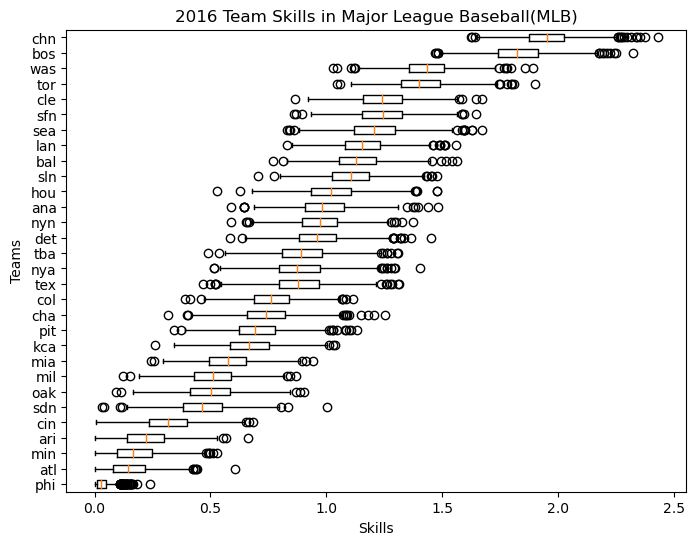

In [56]:
plt.figure(figsize=(8, 6))
plt.boxplot(baseball_skill_df, vert=False)
plt.yticks(code, baseball_skill_df.columns.tolist())
plt.xlabel("Skills")
plt.ylabel("Teams")
plt.title("2016 Team Skills in Major League Baseball(MLB)")
plt.show();